In [12]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np
import random
import operator as op
from functools import reduce
from tqdm import tqdm
import copy
import pickle
from scipy import io
import networkx as nx

In [ ]:
small_network_100times100.ipynb

In [13]:
A_T = np.array([[0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
                        [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
                        [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
                        [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
                        [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
                        [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
                        [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
                        [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
                        [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
                        [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]])

In [14]:
#The purpose of this partitioning appears to be part of the Metropolis-Hastings algorithm.
# The binomial coefficien: C(n, r) = n! / (r! * (n - r)!)
def ncr(n, r):  #n choose r
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

def index_2d(myList, v): #return the exact index
    for i, x in enumerate(myList):
        if v in x:
            return (i, x.index(v))

def l_ij(alpha,beta, A_T,part):       #number of links between group i and j
    link_num = 0
    for a in part[alpha]:
        for b in part[beta]:
            if A_T[a, b] == 1:
                link_num += 1
    return(link_num)


def r_ij(alpha,beta, part):       #maximum possible number of links between group i and j
    return(len(part[alpha]) * len(part[beta]))

In [15]:
def R(i, j, A_T, all_part):   #all_part is a list containing all different partitions
    big_sum= 0
    Z=0
    first_loop_cond = True
    for part in all_part:

        if first_loop_cond:
            gooz_list = [[x,y] for x in range(len(part)) for y in range(len(part)) if len(part[x])<len(part[y])]
            pair_list=[]
            for x in gooz_list:
                if x not in pair_list: pair_list.append(x)

            # H(p) formula
            H_P = 0
            for pair in pair_list:
                alpha, beta = pair
                l = l_ij(alpha, beta, A_T, part)
                r = r_ij(alpha, beta, part)
                h_p = math.log(r+1) + math.log(ncr(r, l))
                H_P += h_p

            Z += np.exp(-H_P)
            first_loop_cond = False
        # print('Pair:',pair,',l:',l,',r:',r,',h_p:',h_p,',H_P:',H_P)


        # define : (l(sigma_i,sigma_j) + 1) / (r(sigma_i,sigma_j) + 2) inside R formula
        sigma_i = index_2d(part, i)[0]
        sigma_j = index_2d(part, j)[0]
        l = l_ij(sigma_i , sigma_j , A_T, part)
        r = r_ij(sigma_i , sigma_j , part)
        parantez = ((l + 1)/(r+2))

        # print(Z)
        big_sum += parantez* np.exp(-H_P)
        R_ij = big_sum/Z
        # print('reliability of i={} and j={}:'.format(i, j), round(R_ij,4))
    return(round(R_ij,5))





In [16]:
# I also define H(P) seperatly because I need it in metropolis function
def H(P,AT_tmp):
    pair_list=[]
    H_P=0
    for i in range(len(P)):
        for j in range(len(P)):
            if i<=j:
                pair_list.append([i,j])
    for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, AT_tmp, P)
            r = r_ij(alpha, beta, P)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
    return(H_P)

In [17]:
def Metropolis(T,ens,AT_tmp):#number of iterations (ensemble size)
    e=[] #store result of simulation
    for i in tqdm(range(ens)):
        partitions =  [[i] for i in range(10)].copy()
        c=0
        for kk in range(T):
            partitions = [ele for ele in partitions if ele != []]
            part_before=copy.deepcopy(partitions)

            H0=H(partitions,AT_tmp) #compute hamiltonian
            rpp=random.randint(0,len(partitions)-1)
            m,n=index_2d(partitions,rpp)
            a=partitions[m][n] #select random partition from rpp
            del partitions[m][n] #delete an element at a specific position in a 2D list
            rp=random.randint(0,len(partitions)-1)
            partitions[rp].append(a) #moves (a) to another random partition rp
            Hf=H(partitions,AT_tmp)
            deltaH=Hf-H0 #calculates the change in energy due to move
            if deltaH>0:
                if random.random() > np.exp(-deltaH):
                    partitions=part_before.copy()
        ppp = [ele for ele in partitions if ele != []]
        e.append(ppp)
        #     partitions = [ele for ele in partitions if ele != []]
        #
        # ppp=copy.deepcopy(partitions)
        # e.append(ppp) # The final partitioning is appended to the e list
        print(H(partitions,AT_tmp))
        print(kk)
    return(e)

In [18]:
es = Metropolis(100, 20,A_T)

100%|██████████| 20/20 [00:00<00:00, 152.87it/s]

18.24081217611948
99
14.286513687543092
99
18.24081217611948
99
22.23085705302248
99
18.240812176119476
99
18.240812176119476
99
22.23085705302248
99
21.748742757251428
99
17.016833223584882
99
21.748742757251428
99
18.240812176119476
99
18.240812176119476
99
21.748742757251424
99
18.240812176119476
99
14.286513687543096
99
18.24081217611948
99
18.240812176119476
99
19.519709612505693
99
13.23017688202322
99
18.240812176119476
99


In [19]:
def link_remover(A_T, ratio): #adjacency matrix :A_T #the ratio of links to be removed:ratio
    one_index = np.where(A_T==1)
    one_list = [[one_index[0][i], one_index[1][i]] for i in range(len(one_index[0]))]
    r = random.sample(one_list, int(ratio * np.sum(A_T)/2)) #randomly selects a subset of the pairs from
    return(r)

#sorting
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()

#extract the first element
def Extract(lst):
    return list(list(zip(*lst))[0])

def acc(k):
    zeros=k.count(0)
    ones=k.count(1)
    ef=0
    for i in range(len(k)):
        if k[i]==1:
            ef+=k[i:].count(0)/zeros
    return ef/ones

In [20]:
zero_real = []
zero_index = np.where(A_T==0)

for i in tqdm(range(len(zero_index[0]))):
    zero_real.append(R(zero_index[0][i], zero_index[1][i], A_T, es))

100%|██████████| 50/50 [00:00<00:00, 13558.00it/s]


In [21]:
rat=np.linspace(0.1,1,10)
accs=[]
for r in rat:
    selected_links = link_remover(A_T, r)
    for link in selected_links: A_T[link[0], link[1]] = 0
    zero_fake=[]
    for i in selected_links:
        zero_fake.append(R(i[0], i[1], A_T, es))
    print('the mean value', round(np.mean(zero_fake),2))
    all_real = []
    for i in zero_fake: all_real.append([1, i])
    for i in zero_real: all_real.append([0, i])
    Sort(all_real)
    ext=Extract(all_real)
    accs.append(acc(ext))

the mean value 14.88
the mean value 14.78
the mean value 12.87
the mean value 9.48
the mean value 9.45
the mean value 5.12
the mean value 5.5
the mean value 4.95
the mean value 3.93
the mean value 3.15


Text(0.5, 1.0, 'Missing intractions')

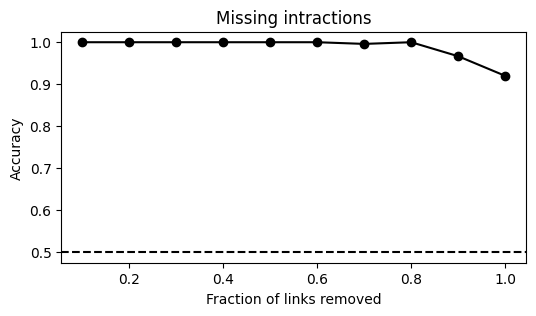

In [22]:
plt.figure(figsize=(6,3))
plt.plot(rat,accs,'-o',color='black')
plt.axhline(y = 0.5, color = 'k', linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links removed')
plt.title('Missing intractions')
